### This file include the AUC-ROC evaluation part. Since it takes too long to run Bert so we only took 30 dataset from each category(positive, neytral, negative) in this notebook 


In [2]:
# Loading data and importing needed package

In [32]:
import re
import nltk
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, make_scorer, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kanghyewon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanghyewon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kanghyewon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
df = pd.read_csv("Tweets.csv")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)    
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)    
    return preprocessed_text

In [34]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [35]:
print(df.dtypes)

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object


In [36]:
print('Total Null Value in the Dataset:')
print(df.isnull().sum())
plt.figure(figsize=(14,8))

Total Null Value in the Dataset:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

Reasons of Negative Tweets:
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


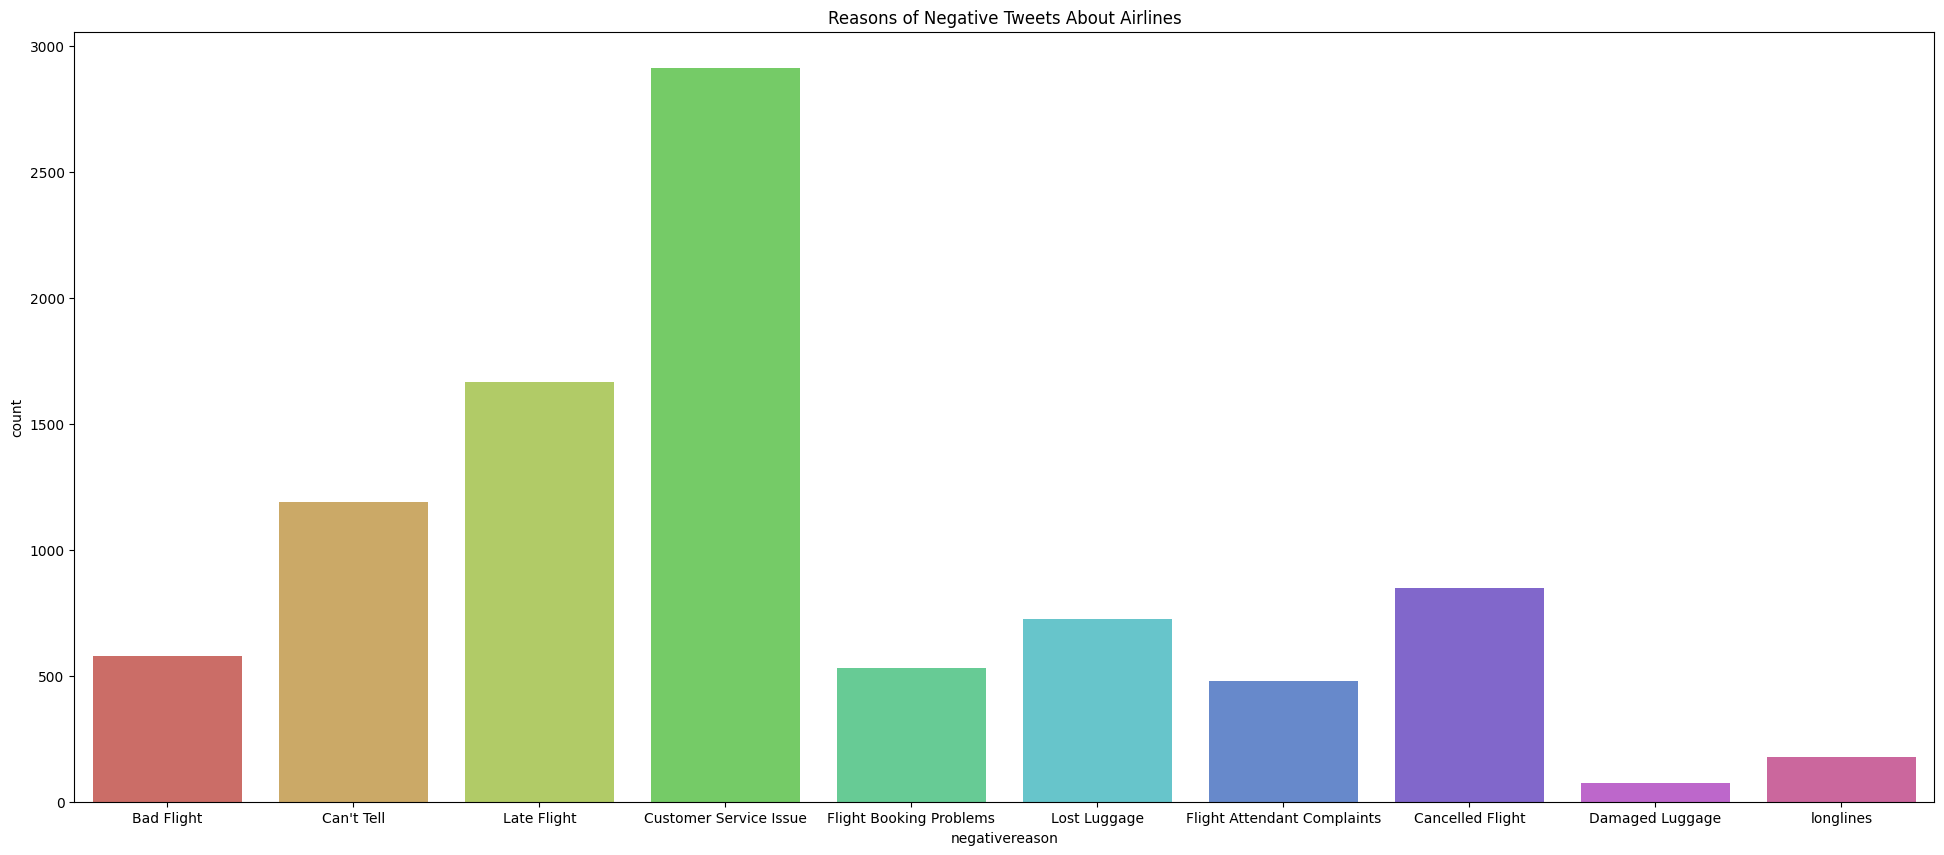

In [37]:
print('Reasons of Negative Tweets:')
print(df.negativereason.value_counts())
plt.figure(figsize=(24,10))
sns.countplot(x='negativereason',data=df, palette='hls')
plt.title('Reasons of Negative Tweets About Airlines')
plt.show()

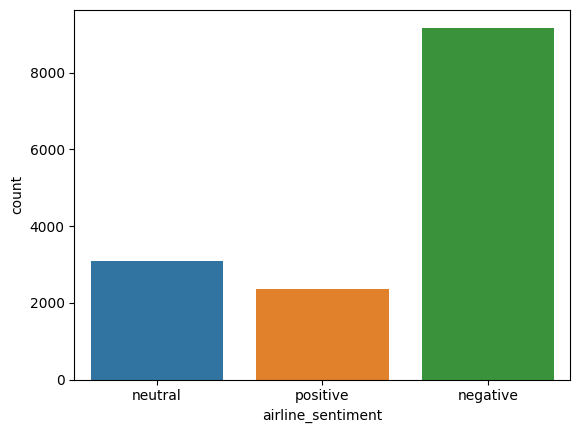

In [38]:
# Unique values of sentiment plot
ax = sns.countplot(x="airline_sentiment", data=df)

### Preprocess Text Data + Splitting into Test sets

In [39]:
# Preprocess the text data
df["preprocessed_text"] = df["text"].apply(preprocess_text)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["preprocessed_text"], df["airline_sentiment"], test_size = 0.2, random_state = 42, stratify = df["airline_sentiment"])

labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

#### Define a function to plot the confusion matrix for ROC-AUC score

In [40]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)
    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test.shape[1])]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_test.shape[1]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= y_test.shape[1]

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(y_test.shape[1]), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

### Multinomial Naive Bayes

##### Hyperparameter optimization using GridSearchCV (Multinomial Naive Bayes)

In [41]:
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid for alpha
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Initialize the MultinomialNB classifier
nb_classifier = MultinomialNB()

# Define the scoring metric with macro F1 score
scoring = make_scorer(f1_score, average='micro')
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, scoring=scoring, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_vect, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best F1 score: {best_score}")

Best alpha: 0.1
Best F1 score: 0.7442793239524095


##### Train and test the MultinomialNB classifier with the best hyperparameters

In [42]:
# Train the MultinomialNB classifier with the best alpha
best_nb_classifier = MultinomialNB(alpha=best_alpha)
best_nb_classifier.fit(X_train_vect, y_train)

# Predict the classes and the probabilities using the best model
predicted_class = best_nb_classifier.predict(X_test_vect)
predicted_class_train = best_nb_classifier.predict(X_train_vect)
test_probs = best_nb_classifier.predict_proba(X_test_vect)
train_probs = best_nb_classifier.predict_proba(X_train_vect)

# Calculate and print the performance metrics
print('Train confusion matrix is:')
print(confusion_matrix(y_train, predicted_class_train))
print('Test confusion matrix is:')
print(confusion_matrix(y_test, predicted_class))
print(classification_report(y_test, predicted_class))

# Calculate train and test accuracy
train_accuracy = accuracy_score(y_train, predicted_class_train)
test_accuracy = accuracy_score(y_test, predicted_class)
print("Train accuracy score: ", train_accuracy)
print("Test accuracy score: ", test_accuracy)

# Calculate and print the AUC-ROC score
train_auc = roc_auc_score(y_train, train_probs, multi_class = 'ovr')
test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr')
print("Train ROC-AUC score:", train_auc)
print("Test ROC-AUC score:", test_auc)

Train confusion matrix is:
[[7255   73   15]
 [ 757 1657   65]
 [ 339   70 1481]]
Test confusion matrix is:
[[1760   47   28]
 [ 356  215   49]
 [ 210   56  207]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1835
           1       0.68      0.35      0.46       620
           2       0.73      0.44      0.55       473

    accuracy                           0.75      2928
   macro avg       0.72      0.58      0.62      2928
weighted avg       0.74      0.75      0.72      2928

Train accuracy score:  0.8873804644808743
Test accuracy score:  0.7452185792349727
Train ROC-AUC score: 0.9779148212911126
Test ROC-AUC score: 0.8721807268297027


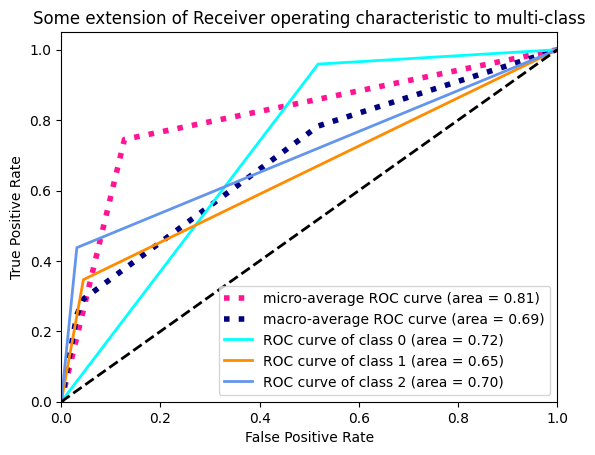

In [43]:
multiclass_roc_auc_score(y_test, predicted_class)

### Logistic Regression

##### Hyperparameter optimization using GridSearchCV (Logistic Regression classifier)

In [44]:
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize the Logistic Regression classifier
log_reg_classifier = LogisticRegression(max_iter=1000)

# Define the scoring metric
scoring = 'f1_macro'  # Using macro F1 score for evaluation

# Initialize GridSearchCV with the classifier, parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=log_reg_classifier, param_grid=param_grid, scoring=scoring, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_vect, y_train)

# Get the best hyperparameters
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Best C: {best_C}")
print(f"Best F1 score: {best_score}")

Best C: 10
Best F1 score: 0.6952939329344827


##### Train and test the Logistic Regression classifier with the best hyperparameters

In [45]:
# Train the Logistic Regression classifier with the best C
best_log_reg_classifier = LogisticRegression(C=best_C, max_iter=1000)
best_log_reg_classifier.fit(X_train_vect, y_train)

# Predict the classes and the probabilities using the best model
predicted_class = best_log_reg_classifier.predict(X_test_vect)
predicted_class_train = best_log_reg_classifier.predict(X_train_vect)  # Train predictions
test_probs = best_log_reg_classifier.predict_proba(X_test_vect)
train_probs = best_log_reg_classifier.predict_proba(X_train_vect)  # Train probabilities

# Calculate and print the performance metrics
print('Train confusion matrix is:')
print(confusion_matrix(y_train, predicted_class_train))
print('Test confusion matrix is:')
print(confusion_matrix(y_test, predicted_class))
print(classification_report(y_test, predicted_class))

# Calculate train and test accuracy
train_accuracy = accuracy_score(y_train, predicted_class_train)
test_accuracy = accuracy_score(y_test, predicted_class)
print("Train accuracy score: ", train_accuracy)
print("Test accuracy score: ", test_accuracy)

# Calculate and print the AUC-ROC score
train_auc = roc_auc_score(y_train, train_probs, multi_class='ovr')  # Train ROC-AUC score
test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr')
print("Train ROC-AUC score:", train_auc)
print("Test ROC-AUC score:", test_auc)

Train confusion matrix is:
[[7242   85   16]
 [ 179 2241   59]
 [  39   45 1806]]
Test confusion matrix is:
[[1643  137   55]
 [ 226  339   55]
 [  86   93  294]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1835
           1       0.60      0.55      0.57       620
           2       0.73      0.62      0.67       473

    accuracy                           0.78      2928
   macro avg       0.72      0.69      0.70      2928
weighted avg       0.77      0.78      0.77      2928

Train accuracy score:  0.9638831967213115
Test accuracy score:  0.7773224043715847
Train ROC-AUC score: 0.9922958489482988
Test ROC-AUC score: 0.8832821501534056


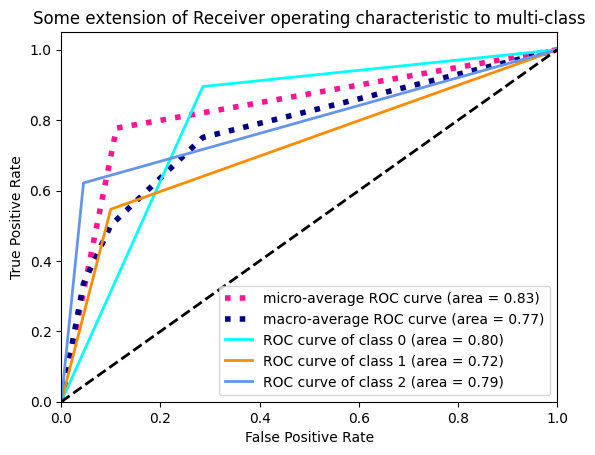

In [46]:
multiclass_roc_auc_score(y_test, predicted_class)

### Random Forest

##### Hyperparameter optimization using GridSearchCV (Random Forest classifier)

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the scoring metric
scoring = 'f1_macro'  # Using macro F1 score for evaluation

# Initialize GridSearchCV with the classifier, parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring, cv=5, n_jobs = -1)

# Fit the grid search to the training data
grid_search.fit(X_train_vect, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 score: 0.6399043434532725


##### Train and test the Random Forest classifier with the best hyperparameters

In [48]:
# Train the Random Forest classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train_vect, y_train)

# Predict the classes and the probabilities using the best model
predicted_class = best_rf_classifier.predict(X_test_vect)
predicted_class_train = best_rf_classifier.predict(X_train_vect)  # Train predictions
test_probs = best_rf_classifier.predict_proba(X_test_vect)
train_probs = best_rf_classifier.predict_proba(X_train_vect)  # Train probabilities

# Calculate and print the performance metrics
print('Train confusion matrix is:')
print(confusion_matrix(y_train, predicted_class_train))
print('Test confusion matrix is:')
print(confusion_matrix(y_test, predicted_class))
print(classification_report(y_test, predicted_class))

# Calculate train and test accuracy
train_accuracy = accuracy_score(y_train, predicted_class_train)
test_accuracy = accuracy_score(y_test, predicted_class)
print("Train accuracy score: ", train_accuracy)
print("Test accuracy score: ", test_accuracy)

# Calculate and print the AUC-ROC score
train_auc = roc_auc_score(y_train, train_probs, multi_class='ovr')  # Train ROC-AUC score
test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr')
print("Train ROC-AUC score:", train_auc)
print("Test ROC-AUC score:", test_auc)

Train confusion matrix is:
[[7326   14    3]
 [   3 2451   25]
 [   4    6 1880]]
Test confusion matrix is:
[[1723   78   34]
 [ 319  266   35]
 [ 161   71  241]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1835
           1       0.64      0.43      0.51       620
           2       0.78      0.51      0.62       473

    accuracy                           0.76      2928
   macro avg       0.73      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

Train accuracy score:  0.9953039617486339
Test accuracy score:  0.7616120218579235
Train ROC-AUC score: 0.9993634926306844
Test ROC-AUC score: 0.8665331158778931


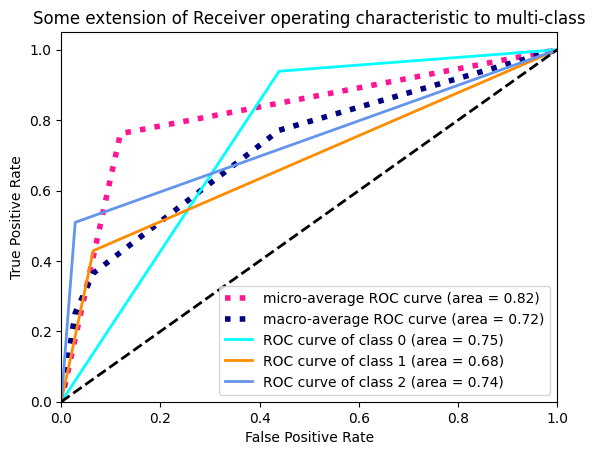

In [49]:
multiclass_roc_auc_score(y_test, predicted_class)

### SVM 

##### Hyperparameter optimization using GridSearchCV (SVM)

In [50]:
from sklearn.svm import SVC

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVM classifier
svm_classifier = SVC(probability=True, random_state=42)

# Define the scoring metric
scoring = 'f1_macro'  # Using macro F1 score for evaluation

# Initialize GridSearchCV with the classifier, parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring=scoring, cv=5, n_jobs = -1)

# Fit the grid search to the training data
grid_search.fit(X_train_vect, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

/Users/kanghyewon/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best F1 score: 0.7010676643630902


##### Train and test the SVM with the best hyperparameters

In [51]:
# Train the SVM classifier with the best parameters
best_svm_classifier = SVC(**best_params, probability=True, random_state=42)
best_svm_classifier.fit(X_train_vect, y_train)

# Predict the classes and the probabilities using the best model
predicted_class = best_svm_classifier.predict(X_test_vect)
predicted_class_train = best_svm_classifier.predict(X_train_vect)  # Train predictions
test_probs = best_svm_classifier.predict_proba(X_test_vect)
train_probs = best_svm_classifier.predict_proba(X_train_vect)  # Train probabilities

# Calculate and print the performance metrics
print('Train confusion matrix is:')
print(confusion_matrix(y_train, predicted_class_train))
print('Test confusion matrix is:')
print(confusion_matrix(y_test, predicted_class))
print(classification_report(y_test, predicted_class))

# Calculate train and test accuracy
train_accuracy = accuracy_score(y_train, predicted_class_train)
test_accuracy = accuracy_score(y_test, predicted_class)
print("Train accuracy score: ", train_accuracy)
print("Test accuracy score: ", test_accuracy)

# Calculate and print the AUC-ROC score
train_auc = roc_auc_score(y_train, train_probs, multi_class='ovr')  # Train ROC-AUC score
test_auc = roc_auc_score(y_test, test_probs, multi_class='ovr')
print("Train ROC-AUC score:", train_auc)
print("Test ROC-AUC score:", test_auc)

Train confusion matrix is:
[[7160  137   46]
 [ 570 1812   97]
 [ 219  111 1560]]
Test confusion matrix is:
[[1686  101   48]
 [ 253  324   43]
 [ 109   74  290]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1835
           1       0.65      0.52      0.58       620
           2       0.76      0.61      0.68       473

    accuracy                           0.79      2928
   macro avg       0.74      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928

Train accuracy score:  0.8992486338797814
Test accuracy score:  0.7855191256830601
Train ROC-AUC score: 0.9675559160302623
Test ROC-AUC score: 0.8918759830985096


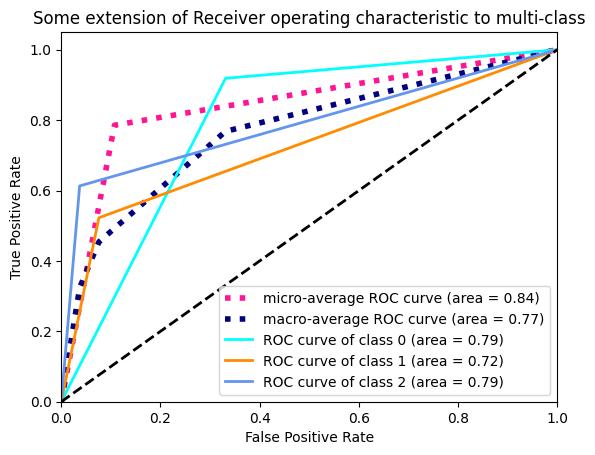

In [52]:
multiclass_roc_auc_score(y_test, predicted_class)

### BERT

In [17]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


The bottom code can be deleted after the code is tested.

In [18]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

In [19]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Assuming 3 classes for sentiment analysis

# Preprocess the text data
df['preprocessed_text'] = df['text'].apply(preprocess_text)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [20]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

## Data select to reduce training time, will select 'n' datas per category. n=select_limited_data

In [47]:
import random
select_limited_data = 30
select_pocket = []
select_key = ["negative", "neutral", "positive"]

for select_item in select_key:
    candidate_index = df['airline_sentiment'].isin([select_item])
    target_index = candidate_index.index[candidate_index]
    select_index = random.choices(list(target_index), k=30)
    select_pocket.extend(select_index)
    
if select_limited_data == -1:
    select_df = df
else:
    select_df = df.loc[select_pocket]
    
select_df['airline_sentiment'].value_counts()

positive    30
negative    30
neutral     30
Name: airline_sentiment, dtype: int64

In [48]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(select_df['preprocessed_text'], select_df['airline_sentiment'], test_size=0.2, random_state=42)

In [49]:
def tokenize_and_create_dataloader(texts, labels, batch_size, shuffle):
    # Encode labels into numerical format and convert to torch.int64
    label_encoder = LabelEncoder()
    labels = torch.tensor(label_encoder.fit_transform(labels), dtype=torch.int64)

    # Tokenize input text
    encoded_dict = tokenizer.batch_encode_plus(
        texts,                      
        add_special_tokens = True, 
        max_length = 64,           
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt',
        truncation = True
    )

    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']

    # Create DataLoader
    dataset = TensorDataset(input_ids, attention_masks, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return loader


In [50]:
import numpy as np
def train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        for idx, batch in enumerate(train_loader):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            print("Epoch: {}/{}, Batch: {}/{}".format(epoch+1, num_epochs, idx+1, len(train_loader)))

    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            logits = outputs.logits.detach().cpu().numpy()
            val_preds.extend(np.argmax(logits, axis=1))
            val_labels.extend(inputs['labels'].detach().cpu().numpy())
            

    train_val_preds = []
    train_val_labels = []

    with torch.no_grad():
        for batch in train_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            logits = outputs.logits.detach().cpu().numpy()
            train_val_preds.extend(np.argmax(logits, axis=1))
            train_val_labels.extend(inputs['labels'].detach().cpu().numpy())

    accuracy = accuracy_score(val_labels, val_preds)
    print("Accuracy:", accuracy)
    return (val_labels, val_preds), (train_val_preds, train_val_labels)

In [51]:
# Preprocess the text data
#df['preprocessed_text'] = df['text'].apply(preprocess_text)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(select_df['preprocessed_text'], select_df['airline_sentiment'], test_size=0.2, random_state=42)


In [52]:
# Create DataLoader for training and testing data
batch_size = 32
train_loader = tokenize_and_create_dataloader(X_train, y_train, batch_size=batch_size, shuffle=True)
test_loader = tokenize_and_create_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

/opt/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [53]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

/opt/anaconda3/lib/python3.7/site-packages/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [54]:
# Train and evaluate the model
(y_test, predicted_class), (y_train, y_train_predict) = train_and_evaluate(model, train_loader, test_loader, num_epochs=3, optimizer=optimizer)


Epoch: 1/3, Batch: 1/3
Epoch: 1/3, Batch: 2/3
Epoch: 1/3, Batch: 3/3
Epoch: 2/3, Batch: 1/3
Epoch: 2/3, Batch: 2/3
Epoch: 2/3, Batch: 3/3
Epoch: 3/3, Batch: 1/3
Epoch: 3/3, Batch: 2/3
Epoch: 3/3, Batch: 3/3
Accuracy: 0.8888888888888888


In [61]:
# Compute AUC-ROC for test set
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        probs = F.softmax(torch.tensor(logits), dim=1).numpy()  
        test_probs.extend(probs)

test_probs = np.array(test_probs)
# Compute AUC-ROC for test set
auc_roc_test = roc_auc_score(y_test, test_probs, multi_class='ovr')

# Compute AUC-ROC for train set
train_probs = []
with torch.no_grad():
    for idx, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        probs = F.softmax(torch.tensor(logits), dim=1).numpy()  
        train_probs.extend(probs)
        print("Current processing... {}/{}".format(idx+1, len(train_loader)))

train_probs = np.array(train_probs)
auc_roc_train = roc_auc_score(y_train, train_probs, multi_class='ovr')

# Print AUC-ROC scores
print("Test ROC-AUC score:", auc_roc_test)
print("Train ROC-AUC score:", auc_roc_train)

# Confusion matrix and classification report
print('Train confusion matrix is: ')
print(confusion_matrix(y_train, y_train_predict))

print('Test confusion matrix is: ')
print(confusion_matrix(y_test, predicted_class))

print('Classification Report:')
# Convert target_names to list of strings
target_names = labelencoder.classes_.astype(str)
print(classification_report(y_test, predicted_class, target_names=target_names))

# Print AUC-ROC
print("Test AUC-ROC:", auc_roc_test)
print("Train AUC-ROC:", auc_roc_train)

Current processing... 1/3
Current processing... 2/3
Current processing... 3/3
Test ROC-AUC score: 1.0
Train ROC-AUC score: 0.6162062479589654
Train confusion matrix is: 
[[22  0  0]
 [ 0 24  0]
 [ 0  0 26]]
Test confusion matrix is: 
[[8 0 0]
 [0 6 0]
 [1 1 2]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.89      1.00      0.94         8
     neutral       0.86      1.00      0.92         6
    positive       1.00      0.50      0.67         4

    accuracy                           0.89        18
   macro avg       0.92      0.83      0.84        18
weighted avg       0.90      0.89      0.87        18

Test AUC-ROC: 1.0
Train AUC-ROC: 0.6162062479589654
